In [58]:
import pandas as pd
import numpy as np
import preprocessing as pp
import formatPredictions as fp
import datasets as datasets

#Importacion arboles
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier

#Importacion preprocesamiento
from sklearn.model_selection import train_test_split

#Importacion metricas
import metrics as m
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

#Librerias para visualizacion
from pprint import pprint
import seaborn as sb
import matplotlib.pyplot as plt

In [59]:
df = datasets.getDataTrain()
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


In [60]:
df_edit = pd.DataFrame()
df_edit = df.copy()

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)
df_new.head()

,tiene_alto_valor_adquisitivo,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
print("Cantidad de features en el nuevo set")
print(len(df_new.columns))

Cantidad de features en el nuevo set
53


In [62]:
# Obtengo los sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = pp.GetSeedForTrainSplit(), test_size=0.20)

# Analisis de hiperparametros

##Random Hyperparameter Grid

In [44]:
# Numero de arboles en random forest
n_estimators = [10, 20, 30, 40, 50]
# Numero de features a considerar en cada split
max_features = ['auto', 'sqrt']
# Maxima profundidad de los arboles
max_depth = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]
max_depth.append(None)
#Minima cantidad de muestras para splitear un nodo
min_samples_split = [2, 5, 10]
# Minima cantidad de muestras en cada hoja 
min_samples_leaf = [1, 2, 4]
# Metodo para seleccionar las muestras para el entrenamiento de cada arbol
bootstrap = [True, False]

In [45]:
# Creo la grilla de parametros
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [46]:
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 30, 40, 50]}


In [47]:
# Creo el modelo
rf = RandomForestClassifier()

In [48]:
# Busco hiperparametros usando 3 fold cross validation con 50 iteraciones cada uno (150 fits).
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state= pp.GetSeedForTrainSplit(), n_jobs = -1)

In [35]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   32.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [36]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 30}

## Grid Search con Cross Validation

In [49]:
# Creo el modelo
rf = RandomForestClassifier()

In [50]:
# Numero de arboles en random forest
n_estimators = [10, 20, 30, 40, 50]
# Numero de features a considerar en cada split
max_features = ['auto', 'sqrt']
# Maxima profundidad de los arboles
max_depth = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]
max_depth.append(None)
#Minima cantidad de muestras para splitear un nodo
min_samples_split = [2, 5, 10]
# Minima cantidad de muestras en cada hoja 
min_samples_leaf = [1, 2, 4]
# Metodo para seleccionar las muestras para el entrenamiento de cada arbol
bootstrap = [True, False]

In [51]:
param_grid  = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [52]:
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 30, 40, 50]}


In [55]:
# Instancio el modelo de grid search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [56]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1980 candidates, totalling 5940 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 5940 out of 5940 | elapsed: 21.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              random_state=None, verbose=0,
                                   

In [57]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 40}

# Predicciones sobre el set de entrenamiento

In [63]:
# n_estimators es el numero de arboles
classifier_random=RandomForestClassifier(bootstrap= False, n_estimators=30, max_depth= None, max_features= 'sqrt', min_samples_leaf=2, min_samples_split=10, random_state=15)
classifier_gridSearch=RandomForestClassifier(bootstrap= False, n_estimators=40, max_depth= None, max_features= 'auto', min_samples_leaf=4, min_samples_split=2, random_state=15)

# Entrenar
classifier_random.fit(X_train, y_train)
classifier_gridSearch.fit(X_train, y_train)
# Predecir
predictions_random=classifier_random.predict(X_test)
predictions_gridSearch=classifier_gridSearch.predict(X_test)

Accuracy: 0.8387839705204975

Precision: 0.6951588502269289

Recall: 0.9185364867596523

F1 Score: 0.636426592797784

Matriz de confusion: 
[[4544  403]
 [ 647  919]]

AUC-ROC: 



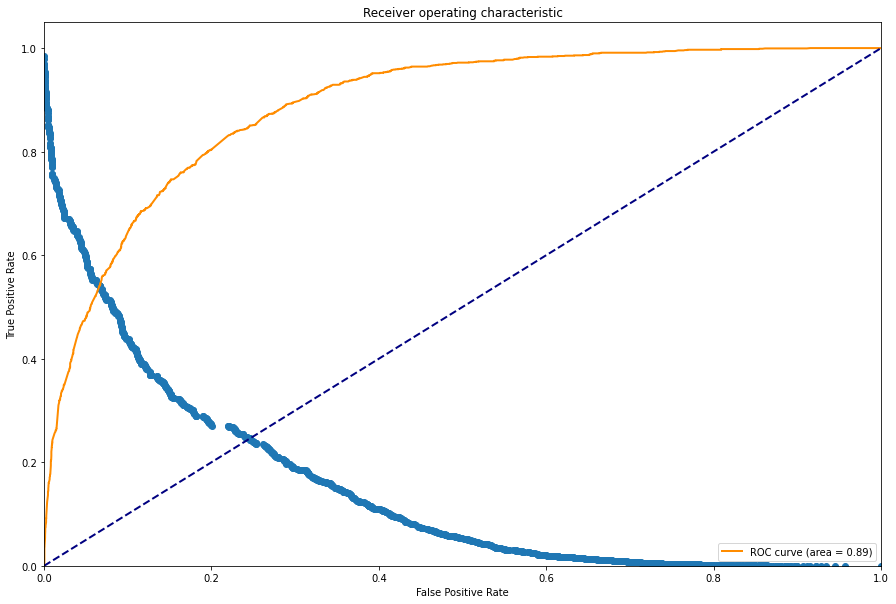

0.8885216500524977

In [64]:
# Obtener metricas random
m.getMetrics(y_test, predictions_random, classifier_random.predict_proba(X_test)[:,1])

Accuracy: 0.8387839705204975

Precision: 0.6925373134328359

Recall: 0.9167172023448554

F1 Score: 0.6386785960082588

Matriz de confusion: 
[[4535  412]
 [ 638  928]]

AUC-ROC: 



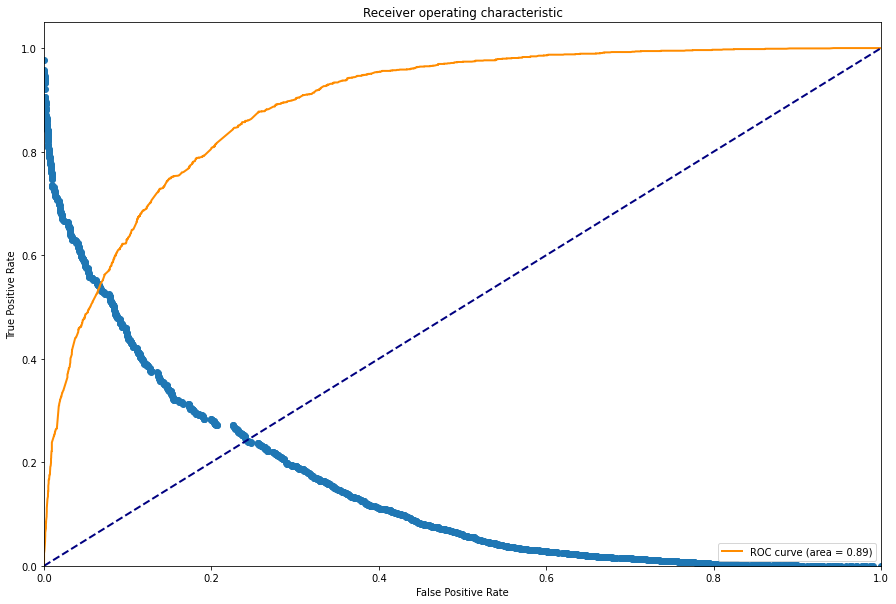

0.8903083412138011

In [65]:
# Obtener metricas random
m.getMetrics(y_test, predictions_gridSearch, classifier_gridSearch.predict_proba(X_test)[:,1])

# Analisis de features de random forest

[1.04781404e-01 3.98851458e-02 1.48233198e-01 1.27823899e-02
 1.21020479e-02 1.76255048e-02 2.23003261e-02 1.23026611e-02
 4.28849033e-06 1.35524559e-04 5.24381748e-03 6.14175899e-03
 3.19641889e-03 1.70837471e-02 3.18453884e-03 1.33674410e-02
 7.30432774e-03 4.61140096e-03 3.83882121e-04 1.50239869e-02
 1.34465141e-02 7.24694679e-03 6.57343713e-03 4.09105994e-02
 2.79106254e-02 1.48676243e-01 1.27349211e-03 3.65606002e-03
 5.84171059e-03 6.62143653e-02 6.67481114e-03 7.93968664e-03
 1.37607311e-02 1.05028072e-02 3.49871943e-03 2.79006965e-02
 5.67299037e-03 2.14434927e-02 1.36796210e-02 4.68584137e-05
 1.20069607e-02 6.35916014e-03 6.15033488e-03 1.51808006e-02
 2.63742566e-02 9.85570899e-03 7.61777851e-03 6.51883743e-03
 7.09783064e-04 1.03205015e-02 7.12240758e-03 1.32192508e-02]


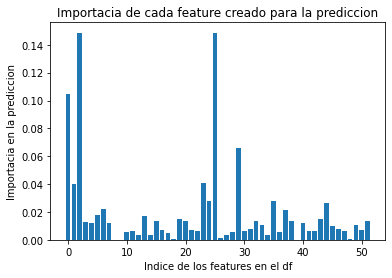

In [66]:
# Ver la importancia de cada feature para este algoritmo
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

print(model.feature_importances_)

# Graficar importancia de cada uno
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Importacia de cada feature creado para la prediccion', )
plt.xlabel('Indice de los features en el df')
plt.ylabel('Importacia en la prediccion')
plt.show()

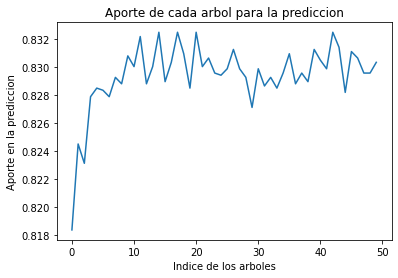

In [67]:
# Ver aporte de cada arbol
trees=range(50)
accuracy=np.zeros(50)

for idx in range(len(trees)):
    classifier=RandomForestClassifier(n_estimators=idx + 1)
    classifier=classifier.fit(X_train, y_train)
    predictions=classifier.predict(X_test)
    accuracy[idx]=accuracy_score(y_test, predictions)

plt.cla()
plt.plot(trees, accuracy)

plt.title('Aporte de cada arbol para la prediccion', )
plt.xlabel('Indice de los arboles')
plt.ylabel('Aporte en la prediccion')
plt.show()

# Prediccion sobre el archivo final

In [10]:
data_test_final = datasets.getDataHoldout()
data_test_final.drop(columns = ["representatividad_poblacional"], inplace=True)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina': 'ganancia_perdida_declarada_bolsa_argentina'}, inplace=True)
data_test_final.head()

,id,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,trabajo
0,1,11,Palermo,relacion_de_dependencia,25,2_anio,sin_matrimonio,0,hombre,40,judaismo,con_hijos,inspector
1,2,13,Palermo,relacion_de_dependencia,38,4_anio,matrimonio_civil,0,hombre,50,cristianismo,casado,sector_primario
2,3,16,Palermo,empleado_municipal,28,universidad_2_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,seguridad
3,4,14,Palermo,relacion_de_dependencia,44,5_anio,matrimonio_civil,7688,hombre,40,judaismo,casado,inspector
4,5,14,Palermo,NaN,18,5_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,NaN


In [11]:
df_test_final = pp.feature_engineering_xg_rf(data_test_final)
df_test_final.head()

,id,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
len(df_test_final.columns)

53

In [13]:
df_test_final.iloc[:, 1:53].head()

,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador
0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [16]:
# Predecir
predictions_final=classifier_gridSearch.predict(df_test_final.iloc[:, 1:53])

predictions_final

array([0, 0, 1, ..., 1, 0, 1])

In [17]:
fp.exportPredictions(fp.formatPredictions(predictions_final), "predictions_final_random_forest")